In [ ]:
!pip install transformers
!pip install pyyaml h5py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import random
from random import shuffle

import itertools

import IPython.display as ipd

import time
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Model, Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/solder/trainval.zip'

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: trainval/train/normal/normal_b2 (462).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b2 (462).tiff  
  inflating: trainval/train/normal/normal_b1 (278).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b1 (278).tiff  
  inflating: trainval/train/normal/normal_b2 (45).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b2 (45).tiff  
  inflating: trainval/train/normal/normal_b2 (683).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b2 (683).tiff  
  inflating: trainval/train/normal/normal_b2 (252).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b2 (252).tiff  
  inflating: trainval/train/normal/normal_b2 (1888).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b2 (1888).tiff  
  inflating: trainval/train/normal/normal_b2 (1337).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b2 (1337).tiff  
  inflating: trainval/train/normal/normal_b2 (1372).tiff  
  inflating: __MACOSX/t

In [ ]:
#tf.debugging.set_log_device_placement(True)

print(tf.__version__)
print('Available GPUs: ', tf.config.list_physical_devices('GPU'))
print(tf.config.experimental.list_logical_devices('GPU'))
print(tf.test.gpu_device_name())

2.14.0
Available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
/device:GPU:0


In [ ]:
seed = 1337

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

batch_size = 64
target_size = (299, 299)

train_gen = image.ImageDataGenerator(rescale = 1./255,
                               rotation_range=10,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest',
                               )

valtest_gen = image.ImageDataGenerator(rescale = 1./255,
                                       fill_mode='nearest',
                                       preprocessing_function=lambda x: smart_resize(x, target_size))

batches = train_gen.flow_from_directory('trainval/train',
                                  target_size=target_size,
                                   batch_size=batch_size,
                                  class_mode='categorical',
                                  shuffle=False,
                                        seed = seed)

val_batches = valtest_gen.flow_from_directory('trainval/val',
                                      target_size=target_size,
                                       batch_size=batch_size,
                                      class_mode='categorical',
                                      shuffle=False,
                                              seed = seed)

Found 2878 images belonging to 5 classes.
Found 511 images belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:202: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


In [ ]:
inception = InceptionV3(include_top=True,
                  weights='imagenet',
                  input_tensor=None,
                  input_shape=(299,299,3),
                  pooling=None)

x = inception.layers[-2].output
output_layer = Dense(5, activation='softmax', name='predictions')(x)

model = Model(inputs=inception.input, outputs=output_layer)

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='acc'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='categorical_crossentropy', metrics=METRICS)

epochs = 50

lr_scheduler = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x)

with tf.device('/GPU:0'):
    history = model.fit(batches,
              validation_data = val_batches,
              epochs = epochs,
              callbacks=lr_scheduler)
model.summary()
model.save('/content/drive/MyDrive/solder/model/inceptionbase.h5')


96112376/96112376 [==============================] - 1s 0us/step
Epoch 1/50
45/45 [==============================] - 157s 2s/step - loss: 0.9024 - acc: 0.7707 - precision: 0.8012 - recall: 0.6706 - auc: 0.8770 - val_loss: 0.8712 - val_acc: 0.8043 - val_precision: 0.8043 - val_recall: 0.8043 - val_auc: 0.9175 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 89s 2s/step - loss: 0.4928 - acc: 0.8075 - precision: 0.9208 - recall: 0.7953 - auc: 0.9696 - val_loss: 0.7042 - val_acc: 0.8043 - val_precision: 0.8043 - val_recall: 0.8043 - val_auc: 0.9478 - lr: 9.0000e-05
Epoch 3/50
45/45 [==============================] - 89s 2s/step - loss: 0.3570 - acc: 0.8919 - precision: 0.9230 - recall: 0.8367 - auc: 0.9828 - val_loss: 0.5166 - val_acc: 0.8063 - val_precision: 0.8545 - val_recall: 0.8043 - val_auc: 0.9720 - lr: 8.1000e-05
Epoch 4/50
45/45 [==============================] - 94s 2s/step - loss: 0.3332 - acc: 0.8589 - precision: 0.9798 - recall: 0.8082 - auc: 0.9834 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


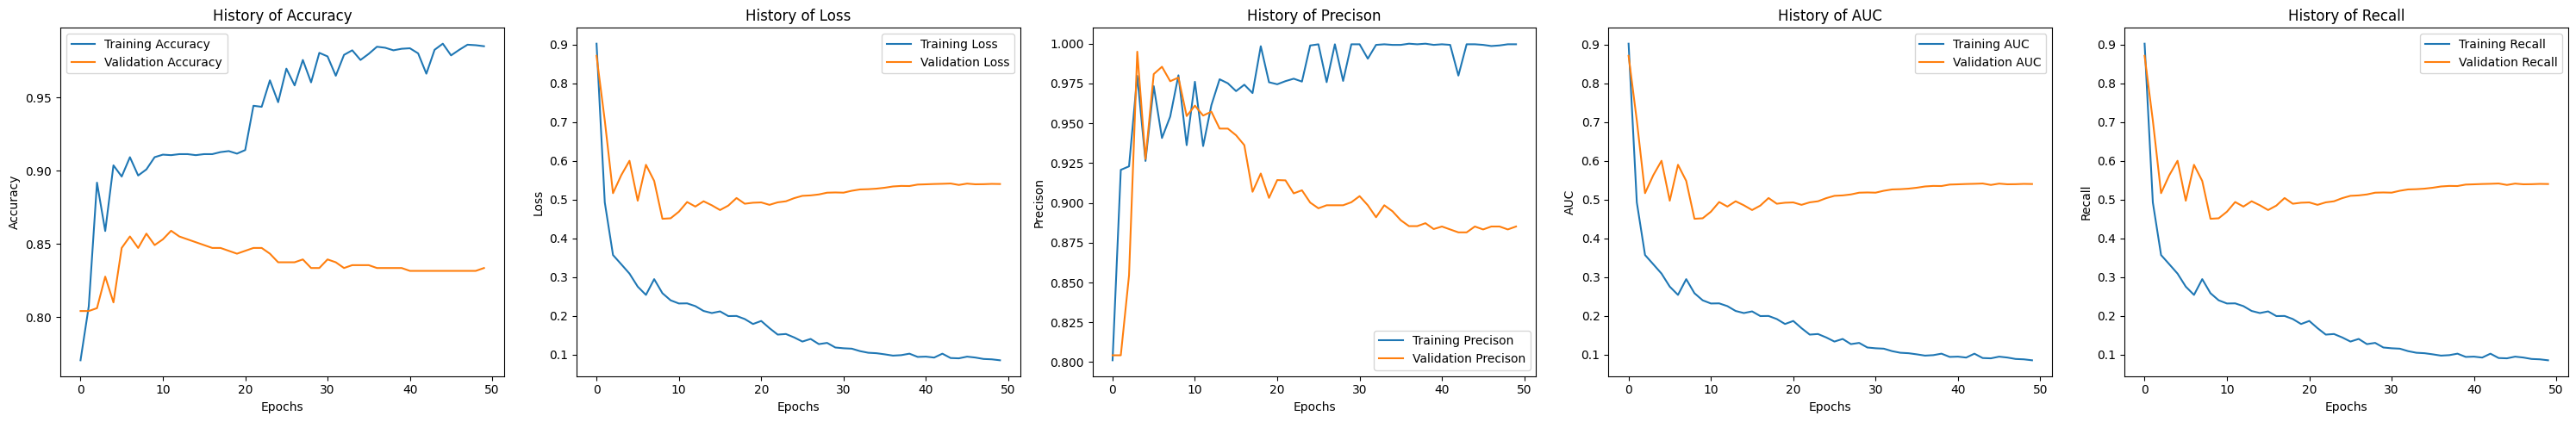

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

auc = history.history['auc']
val_auc = history.history['val_auc']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['recall']

epochs_range = range(epochs)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize= (30,5))

ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

ax3.plot(epochs_range, precision, label='Training Precison')
ax3.plot(epochs_range, val_precision, label='Validation Precison')
ax3.set_title('History of Precison')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Precison')

ax4.plot(epochs_range, loss, label='Training AUC')
ax4.plot(epochs_range, val_loss, label='Validation AUC')
ax4.set_title('History of AUC')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('AUC')

ax5.plot(epochs_range, loss, label='Training Recall')
ax5.plot(epochs_range, val_loss, label='Validation Recall')
ax5.set_title('History of Recall')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('Recall')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
fig.tight_layout()

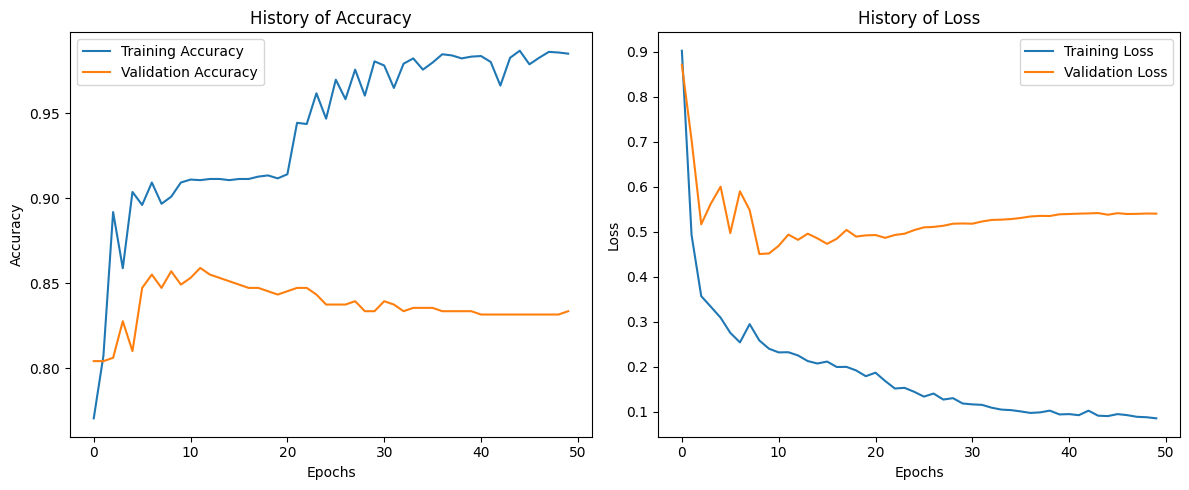

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (12,5))

ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

ax1.legend()
ax2.legend()
fig.tight_layout()


<ipython-input-12-3bf2d159b306>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(val_batches, val_batches.samples // batch_size+1)


Confusion Matrix
[[  0   6   8   0   0]
 [  0  14   9   0   0]
 [  0   0 411   0   0]
 [  0   9   8   1   0]
 [  0  10  35   0   0]]
Classification Report
                     precision    recall  f1-score   support

   excessive_solder       0.00      0.00      0.00        14
insufficient_solder       0.36      0.61      0.45        23
             normal       0.87      1.00      0.93       411
  shifted_component       1.00      0.06      0.11        18
              short       0.00      0.00      0.00        45

           accuracy                           0.83       511
          macro avg       0.45      0.33      0.30       511
       weighted avg       0.75      0.83      0.77       511



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


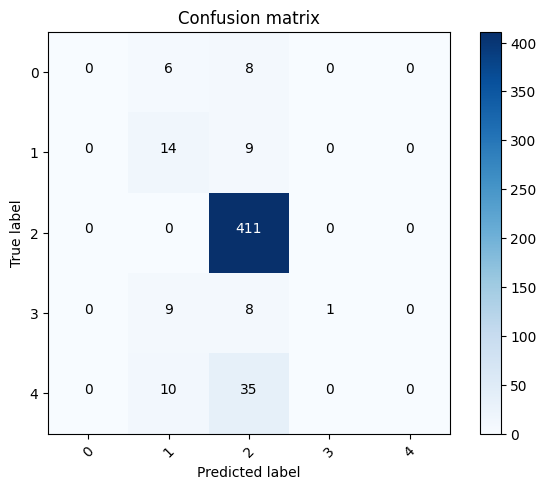

In [ ]:
Y_pred = model.predict_generator(val_batches, val_batches.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
conf_matrix = confusion_matrix(val_batches.classes, y_pred)
print(conf_matrix)
np.savetxt("conf_matrix.csv", conf_matrix, delimiter=",", fmt="%s")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(conf_matrix, classes = range(5))

print('Classification Report')
target_names = np.array(list(val_batches.class_indices.keys()))
print(classification_report(val_batches.classes, y_pred, target_names=target_names))